In [1]:
#qrsh -P steinlab -l h_vmem=30G,h_rt=03:00:00:00,gpu=1,cuda.0.name="Tesla*" -q gpu.q
#module load singularity/3.8.2
#cd ~/adiaz/projects/genome_simulator/mutations_distribution/gan/ctgan
#singularity exec --writable -B $(pwd):/outdir /u/adiaz-navarro/adiaz/venv/singularity/ctgan_sandbox.sif bash -c "cd /outdir && jupyter-lab --no-browser --port 8890 --ip=`hostname`"

In [2]:
import os
import pickle
import pandas as pd
from sdv.datasets.local import load_csvs
from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer, TVAESynthesizer
import matplotlib.pyplot as plt

# Step 1 - CTGAN

In [3]:
# Import external data
datasets = load_csvs(folder_name='datasets/')
gan = datasets['gan_mut_v11_positions_CNS-PiloAstro_step1_100w_div100'] #SECTION - Update path

In [4]:
# Remove ranks with less than 2 mutations
gan = gan.loc[gan.groupby('rank')['rank'].transform('size') >= 3]

In [5]:
# Detect metadata
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=gan)

# Validate metadata
metadata.validate()
metadata

{
    "columns": {
        "rank": {
            "sdtype": "categorical"
        }
    },
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1"
}

In [6]:
# Parameters
epochs = 50
batch_size = 300 #300
discriminator_dim = (8,8) #(256,256)
discriminator_decay = 1e-6 #Discriminator weight decay for the Adam Optimizer #1e-6
discriminator_lr = 2e-4 #2e-4
discriminator_steps = 2 #1
embedding_dim = 128 #Size of the random sample passed to the Generator #128
generator_dim = (8,8) #(256,256)
generator_decay = 1e-6 #Generator weight decay for the Adam Optimizer #1e-6
generator_lr = 2.5e-4 #2e-4
pac = 10 #10

# Print parameters
discriminator_dim_print = f'{discriminator_dim[0]}_{discriminator_dim[1]}'
generator_dim_print = f'{generator_dim[0]}_{generator_dim[1]}'

# Define synthesizer options
synthesizer = CTGANSynthesizer(metadata,
                               epochs = epochs,
                               batch_size = batch_size,
                               discriminator_dim = discriminator_dim,
                               discriminator_decay = discriminator_decay,
                               discriminator_lr =discriminator_lr,
                               discriminator_steps = discriminator_steps,
                               embedding_dim = embedding_dim,
                               generator_dim = generator_dim,
                               generator_decay = generator_decay,
                               generator_lr = generator_lr,
                               pac = pac,
                               verbose = True,
                               enforce_min_max_values = False)

In [7]:
# Transform the columns
synthesizer.auto_assign_transformers(gan)
synthesizer.get_transformers()

{'rank': None}

In [8]:
# Train the model
synthesizer.fit(gan)
synthesizer.save(filepath=f'/outdir/tmp_training/CNS-PiloAstro_ctgan_ep{epochs}_bs{batch_size}_ddim{discriminator_dim_print}_dlr{discriminator_lr}_ds{discriminator_steps}_edim{embedding_dim}_gdim{generator_dim_print}_glr{generator_lr}_pac{pac}_v11_step1_div100.pkl') #SECTION - Update path

Gen. (-0.09) | Discrim. (0.02): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:08<00:00,  2.57s/it]


In [9]:
# Simulate data
synthetic_data = synthesizer.sample(num_rows=gan.shape[0])

## Compare real vs simulated results

In [10]:
# Sort the ranks
conversion = pd.DataFrame({'rank': pd.concat([gan['rank'], synthetic_data['rank']]).unique()})
conversion['conv'] = range(len(conversion))

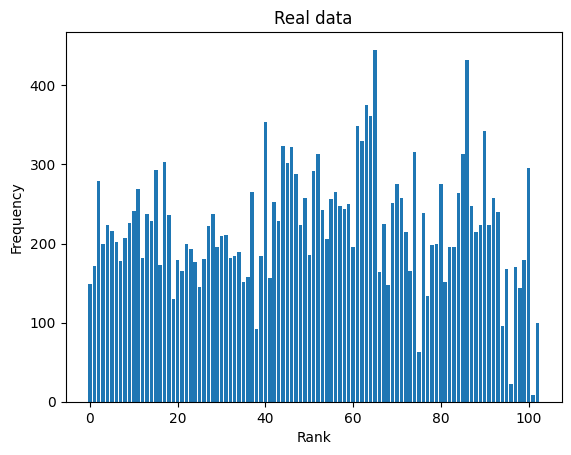

In [11]:
# Real data
gan_bar = gan.merge(conversion, on='rank', how='left')
bar_pd = pd.crosstab(index=gan_bar['conv'], columns='count')
plt.bar(x = bar_pd['count'].index, height = bar_pd['count'])
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.title('Real data')
plt.show()

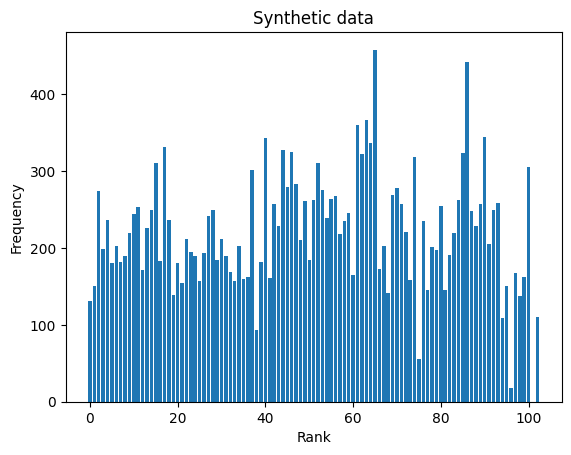

In [12]:
# Synthetic data
synthetic_bar = synthetic_data.merge(conversion, on='rank', how='left')
bar_pd = pd.crosstab(index=synthetic_bar['conv'], columns='count')
plt.bar(x = bar_pd['count'].index, height = bar_pd['count'])
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.title('Synthetic data')
plt.show()

# Step 2 - TVAE

In [13]:
# Import external data
datasets = load_csvs(folder_name='datasets/')
gan = datasets['gan_mut_v11_positions_CNS-PiloAstro_step2_start_div100'] #SECTION - Update path

In [14]:
# Remove ranks with less than 2 mutations
gan = gan.loc[gan.groupby('rank')['rank'].transform('size') >= 3]

In [15]:
# Generate step1 data
synthesizer = CTGANSynthesizer.load('/outdir/tmp_training/CNS-PiloAstro_ctgan_ep50_bs300_ddim8_8_dlr0.0002_ds2_edim128_gdim8_8_glr0.00025_pac10_v11_step1_div100.pkl') #SECTION - Update path
synthetic_data = synthesizer.sample(num_rows=gan.shape[0])

In [16]:
# For each window from step1
rank1 = gan['rank'].unique()

# Define parameters
epochs = 3000
batch_size = 5000 #300
compress_dims = (256,256) #Size of each hidden layer in the encoder #(128, 128)
decompress_dims = (256,256) #Size of each hidden layer in the decoder #(128, 128)
embedding_dim = 128 #Size of the random sample passed to the Generator #128
l2scale = 1e-5 #1-e5
loss_factor = 2 #2

# Print paramaters
compress_dims_print = f'{compress_dims[0]}_{compress_dims[1]}'
decompress_dims_print = f'{decompress_dims[0]}_{decompress_dims[1]}'

synthetic_data2:pd.DataFrame = pd.DataFrame()
for (idx,window) in enumerate(rank1):

    if idx == 103: #The last rank only has 1 row
        continue
    
    # Make a subset
    tmp = pd.DataFrame({'start': gan['start'][gan['rank'] == window]})
    
    # Detect metadata
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(data=tmp)
        
    # Define synthesizer options
    synthesizer = TVAESynthesizer(metadata,
                              epochs = epochs,
                              batch_size = batch_size,
                              compress_dims = compress_dims,
                              decompress_dims = decompress_dims,
                              embedding_dim =embedding_dim,
                              l2scale = l2scale,
                              loss_factor = loss_factor,
                              enforce_min_max_values = True)
    
    # Transform the columns
    synthesizer.auto_assign_transformers(tmp)

    # Train the model
    synthesizer.fit(tmp)
    synthesizer.save(filepath=f'/outdir/tmp_training/CNS-PiloAstro_{idx}_tvae_ep{epochs}_bs{batch_size}_cdim{compress_dims_print}_edim{embedding_dim}_ddim{decompress_dims_print}_v11_step2_div100.pkl') #SECTION - Update path

    # Simulate data
    nrow = synthetic_data[synthetic_data['rank'] == window].shape[0]
    tmp_synthetic_data = synthesizer.sample(num_rows=nrow)
    
    # Concatenate the data
    synthetic_data2 = pd.concat([synthetic_data2, tmp_synthetic_data])

    # Plot the results
    ## Plot the original data
    # plt.hist(tmp['start'], alpha=0.6, color='r', bins=30, label='Histogram')
    # plt.xlabel('Value')
    # plt.ylabel('Frequency')
    # plt.title('Original Data')
    # # tmp.plot(kind='density')
    # plt.show()
    # ## Plot the synthetic data
    # plt.hist(tmp_synthetic_data['start'], alpha=0.6, color='b', bins=30, label='Histogram')
    # # tmp_synthetic_data.plot(kind='density')
    # plt.show()

# Save simulated data
synthetic_data2.to_csv(f'/outdir/tmp_csv/CNS-PiloAstro_tvae_ep{epochs}_bs{batch_size}_cdim{compress_dims_print}_edim{embedding_dim}_ddim{decompress_dims_print}_v11_step2_start_div100.csv',
                      index=False) #SECTION - Update path
synthetic_data.to_csv(f'/outdir/tmp_csv/CNS-PiloAstro_tvae_ep{epochs}_bs{batch_size}_cdim{compress_dims_print}_edim{embedding_dim}_ddim{decompress_dims_print}_v11_step1_rank_div100.csv',
                      index=False) #SECTION - Update path

# Step 3 - Save the models into a pickle

In [18]:
posModel = {}

# Step1 model
posModel['step1'] = CTGANSynthesizer.load('/outdir/tmp_training/CNS-PiloAstro_ctgan_ep50_bs300_ddim8_8_dlr0.0002_ds2_edim128_gdim8_8_glr0.00025_pac10_v11_step1_div100.pkl') #SECTION - Update path

# Step2 models
for (idx,window) in enumerate(rank1):
    posModel[window] = TVAESynthesizer.load(f'/outdir/tmp_training/CNS-PiloAstro_{idx}_tvae_ep3000_bs5000_cdim256_256_edim128_ddim256_256_v11_step2_div100.pkl') #SECTION - Update path

# Save the dictionary into a pickle file
with open('/outdir/CNS-PiloAstro_positions2.pkl', 'wb') as handle: #SECTION - Update path
    pickle.dump(posModel, handle, protocol=pickle.HIGHEST_PROTOCOL)
